In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
import cv2
from matplotlib import pyplot as plt
import os
import tensorflow as tf
import re
import sys
from tqdm import tqdm
from tensorflow import keras

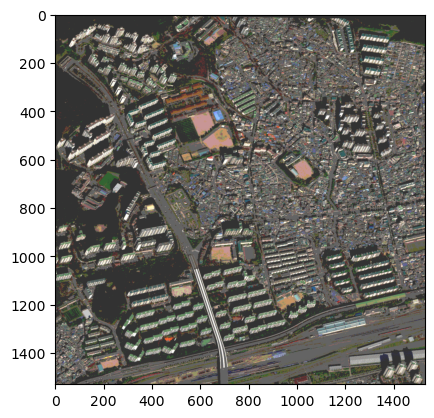

In [2]:

#import pictures and cut into slices
input_path = "../cse-seminar/inputs/tifBusan.tif"
img = cv2.imread(input_path)
img = cv2.convertScaleAbs(img, alpha = 50,beta = 50)
img = cv2.resize(img,(1530,1530))
plt.imshow(img)


# dimensions of the original image
height, width, _ = img.shape

# Define dimensions for each smaller image
small_width = width // 10
small_height = height // 10

# Slice the original image into smaller images
small_images = []
for row in range(10):
    for col in range(10):
        # starting and ending points of each small image
        start_x = col * small_width
        end_x = (col + 1) * small_width
        start_y = row * small_height
        end_y = (row + 1) * small_height

        # Extract from the original image
        small_image = img[start_y:end_y, start_x:end_x]

        # Append small image to list
        small_images.append(small_image)

# save smaller images
output_path = "../cse-seminar/small_images/"
for i, small_image in enumerate(small_images):
    cv2.imwrite( '../cse-seminar/small_images/small_image%d.png' % i, small_image)


In [3]:
# Add Metrics
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(tf.subtract(tf.add(y_true, y_pred), tf.multiply(y_true, y_pred)))
    iou_score = tf.divide(intersection, union)
    return iou_score

In [4]:
# load small images
image_path = []
for root, dirs, files in os.walk('../cse-seminar/small_images_withlabel'):
    # iterate over 1000 images
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        image_path.append(path)

images = []
testimg = []

for path in image_path:
    file = tf.io.read_file(path)
    img = tf.image.decode_png(file, channels=3, dtype=tf.uint8)
    testimg.append(img)

100%|██████████| 68/68 [00:00<00:00, 3569.75it/s]


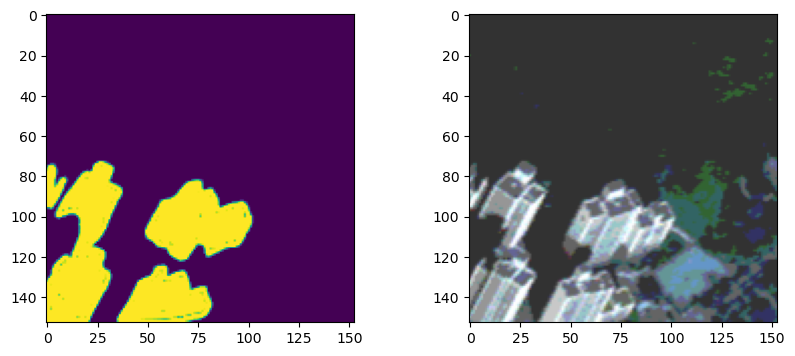

In [5]:
# a list to collect paths masks
mask_path = []
for root, dirs, files in os.walk('../cse-seminar/labeled_data'):
    #iterate over 1000 masks
    for file in files:
        # obtain the path
        path = os.path.join(root,file)
        # add path to the list
        mask_path.append(path)

# create a list to store masks
testmasks = []
# iterate over mask paths
for path in tqdm(mask_path):
    # read the file
    mask = np.load(path)
    # add channel
    mask = mask[..., tf.newaxis]
    # append mask to the list
    testmasks.append(mask)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(testmasks[2])
ax2.imshow(testimg[2])

In [6]:
# Split data into train and test
def normalize_image(input_image):
    input_image = tf.cast(input_image, tf.float32)
    input_image = input_image/ 255.0
    input_image = tf.image.resize(input_image, (128,128))
    return input_image

def normalize_mask(input_mask):
    input_mask = input_mask/ 255.0
    input_mask = tf.image.resize(input_mask, (128,128))
    input_mask = tf.cast(input_mask, tf.uint8)
    return input_mask

testimg = [normalize_image(i) for i in testimg]
testmasks =  [normalize_mask(m) for m in testmasks]

X_train, X_test, y_train, y_test = train_test_split(testimg, testmasks, test_size=0.2, random_state=42)

X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_test = tf.data.Dataset.from_tensor_slices(X_test)

y_train = tf.data.Dataset.from_tensor_slices(y_train)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

X_train.element_spec, y_train.element_spec, X_test.element_spec, y_test.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

In [7]:
# adjust brightness of image
# don't alter in mask
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

# adjust gamma of image
# don't alter in mask
def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

# adjust hue of image
# don't alter in mask
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    # crop both image and mask identically
    img = tf.image.central_crop(img, 0.7)
    # resize after cropping
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    # resize afer cropping
    mask = tf.image.resize(mask, (128,128))
    # cast to integers as they are class numbers
    mask = tf.cast(mask, tf.uint8)
    return img, mask

# flip both image and mask identically
def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

# flip both image and mask identically
def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

# rotate both image and mask identically
def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

In [8]:
# zip images and masks
train = tf.data.Dataset.zip((X_train, y_train))
val = tf.data.Dataset.zip((X_test, y_test))

# perform augmentation on train data only

a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_hori)
f = train.map(flip_vert)
g = train.map(rotate)

# concatenate every new augmented sets
train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g)

In [9]:
BATCH = 5
AT = tf.data.AUTOTUNE
BUFFER = 100

STEPS_PER_EPOCH = 54 //BATCH
VALIDATION_STEPS = 14 //BATCH

train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

In [10]:
# Use pre-trained DenseNet121 without head
base = keras.applications.DenseNet121(input_shape=[128,128,3],
                                      include_top=False,
                                      weights='imagenet',
                                      )

In [11]:
len(base.layers)

427

In [12]:
#final ReLU activation layer for each feature map size, i.e. 4, 8, 16, 32, and 64, required for skip-connections
skip_names = ['conv1/relu', # size 64*64
             'pool2_relu',  # size 32*32
             'pool3_relu',  # size 16*16
             'pool4_relu',  # size 8*8
             'relu'        # size 4*4
             ]

In [13]:
#output of these layers
skip_outputs = [base.get_layer(name).output for name in skip_names]
for i in range(len(skip_outputs)):
    print(skip_outputs[i])

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='conv1/relu/Relu:0', description="created by layer 'conv1/relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='pool2_relu/Relu:0', description="created by layer 'pool2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='pool3_relu/Relu:0', description="created by layer 'pool3_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1024), dtype=tf.float32, name=None), name='pool4_relu/Relu:0', description="created by layer 'pool4_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [14]:
#Building the downstack with the above layers. We use the pre-trained model as such, without any fine-tuning.
downstack = keras.Model(inputs=base.input,
                       outputs=skip_outputs)
# freeze the downstack layers
downstack.trainable = False

In [15]:
!pip install -q git+https://github.com/tensorflow/examples.git --quiet

In [16]:
from tensorflow_examples.models.pix2pix import pix2pix
# Four upstack layers for upsampling sizes
# 4->8, 8->16, 16->32, 32->64
upstack = [pix2pix.upsample(512,3),
          pix2pix.upsample(256,3),
          pix2pix.upsample(128,3),
          pix2pix.upsample(64,3)]

In [17]:
upstack[1].layers

In [18]:
# define the input layer
inputs = keras.layers.Input(shape=[128,128,3])

# downsample
down = downstack(inputs)
out = down[-1]

# prepare skip-connections
skips = reversed(down[:-1])
# choose the last layer at first 4 --> 8

# upsample with skip-connections
for up, skip in zip(upstack,skips):
    out = up(out)
    out = keras.layers.Concatenate()([out,skip])

# define the final transpose conv layer
# image 128 by 128 with 59 classes
out = keras.layers.Conv2DTranspose(2, 3,
                                  strides=2,
                                  padding='same',
                                  )(out)
# complete unet model
unet = keras.Model(inputs=inputs, outputs=out)

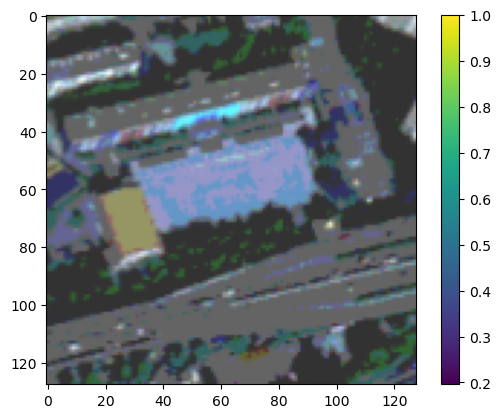

In [19]:
#checking for model and data compatibility
# infer on train dataset
example = next(iter(train))
preds = unet(example[0])
# visualize an image
plt.imshow(example[0][0])
plt.colorbar()
plt.show()

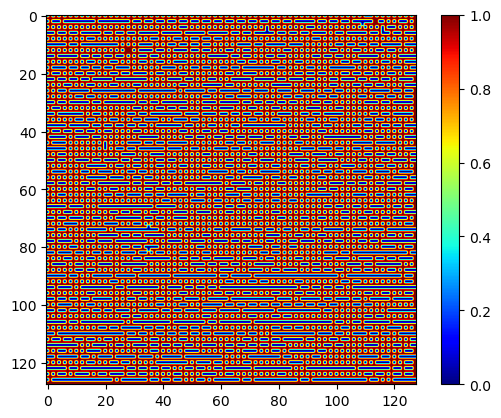

In [20]:
pred_mask = tf.argmax(preds, axis=-1)
pred_mask = tf.expand_dims(pred_mask, -1)
plt.imshow(pred_mask[0], cmap='jet')
plt.colorbar()

In [21]:
# compiling the model
def Compile_Model():
    unet.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])
Compile_Model()

In [22]:
#training and fine-tuning
hist_1 = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=20,
               verbose=2)

Epoch 1/20
10/10 - 12s - loss: 0.4577 - accuracy: 0.8226 - val_loss: 0.5765 - val_accuracy: 0.8416 - 12s/epoch - 1s/step
Epoch 2/20
10/10 - 4s - loss: 0.3338 - accuracy: 0.8812 - val_loss: 0.5336 - val_accuracy: 0.8416 - 4s/epoch - 372ms/step
Epoch 3/20
10/10 - 4s - loss: 0.2592 - accuracy: 0.8989 - val_loss: 0.4783 - val_accuracy: 0.8422 - 4s/epoch - 369ms/step
Epoch 4/20
10/10 - 4s - loss: 0.1968 - accuracy: 0.9211 - val_loss: 0.4227 - val_accuracy: 0.8434 - 4s/epoch - 371ms/step
Epoch 5/20
10/10 - 4s - loss: 0.2019 - accuracy: 0.9169 - val_loss: 0.4162 - val_accuracy: 0.8696 - 4s/epoch - 370ms/step
Epoch 6/20
10/10 - 4s - loss: 0.2166 - accuracy: 0.9088 - val_loss: 0.4193 - val_accuracy: 0.8949 - 4s/epoch - 365ms/step
Epoch 7/20
10/10 - 4s - loss: 0.1970 - accuracy: 0.9217 - val_loss: 0.3459 - val_accuracy: 0.8911 - 4s/epoch - 370ms/step
Epoch 8/20
10/10 - 4s - loss: 0.1599 - accuracy: 0.9364 - val_loss: 0.3010 - val_accuracy: 0.8924 - 4s/epoch - 364ms/step
Epoch 9/20
10/10 - 4s - l

1/1 [==============================] - 2s 2s/step


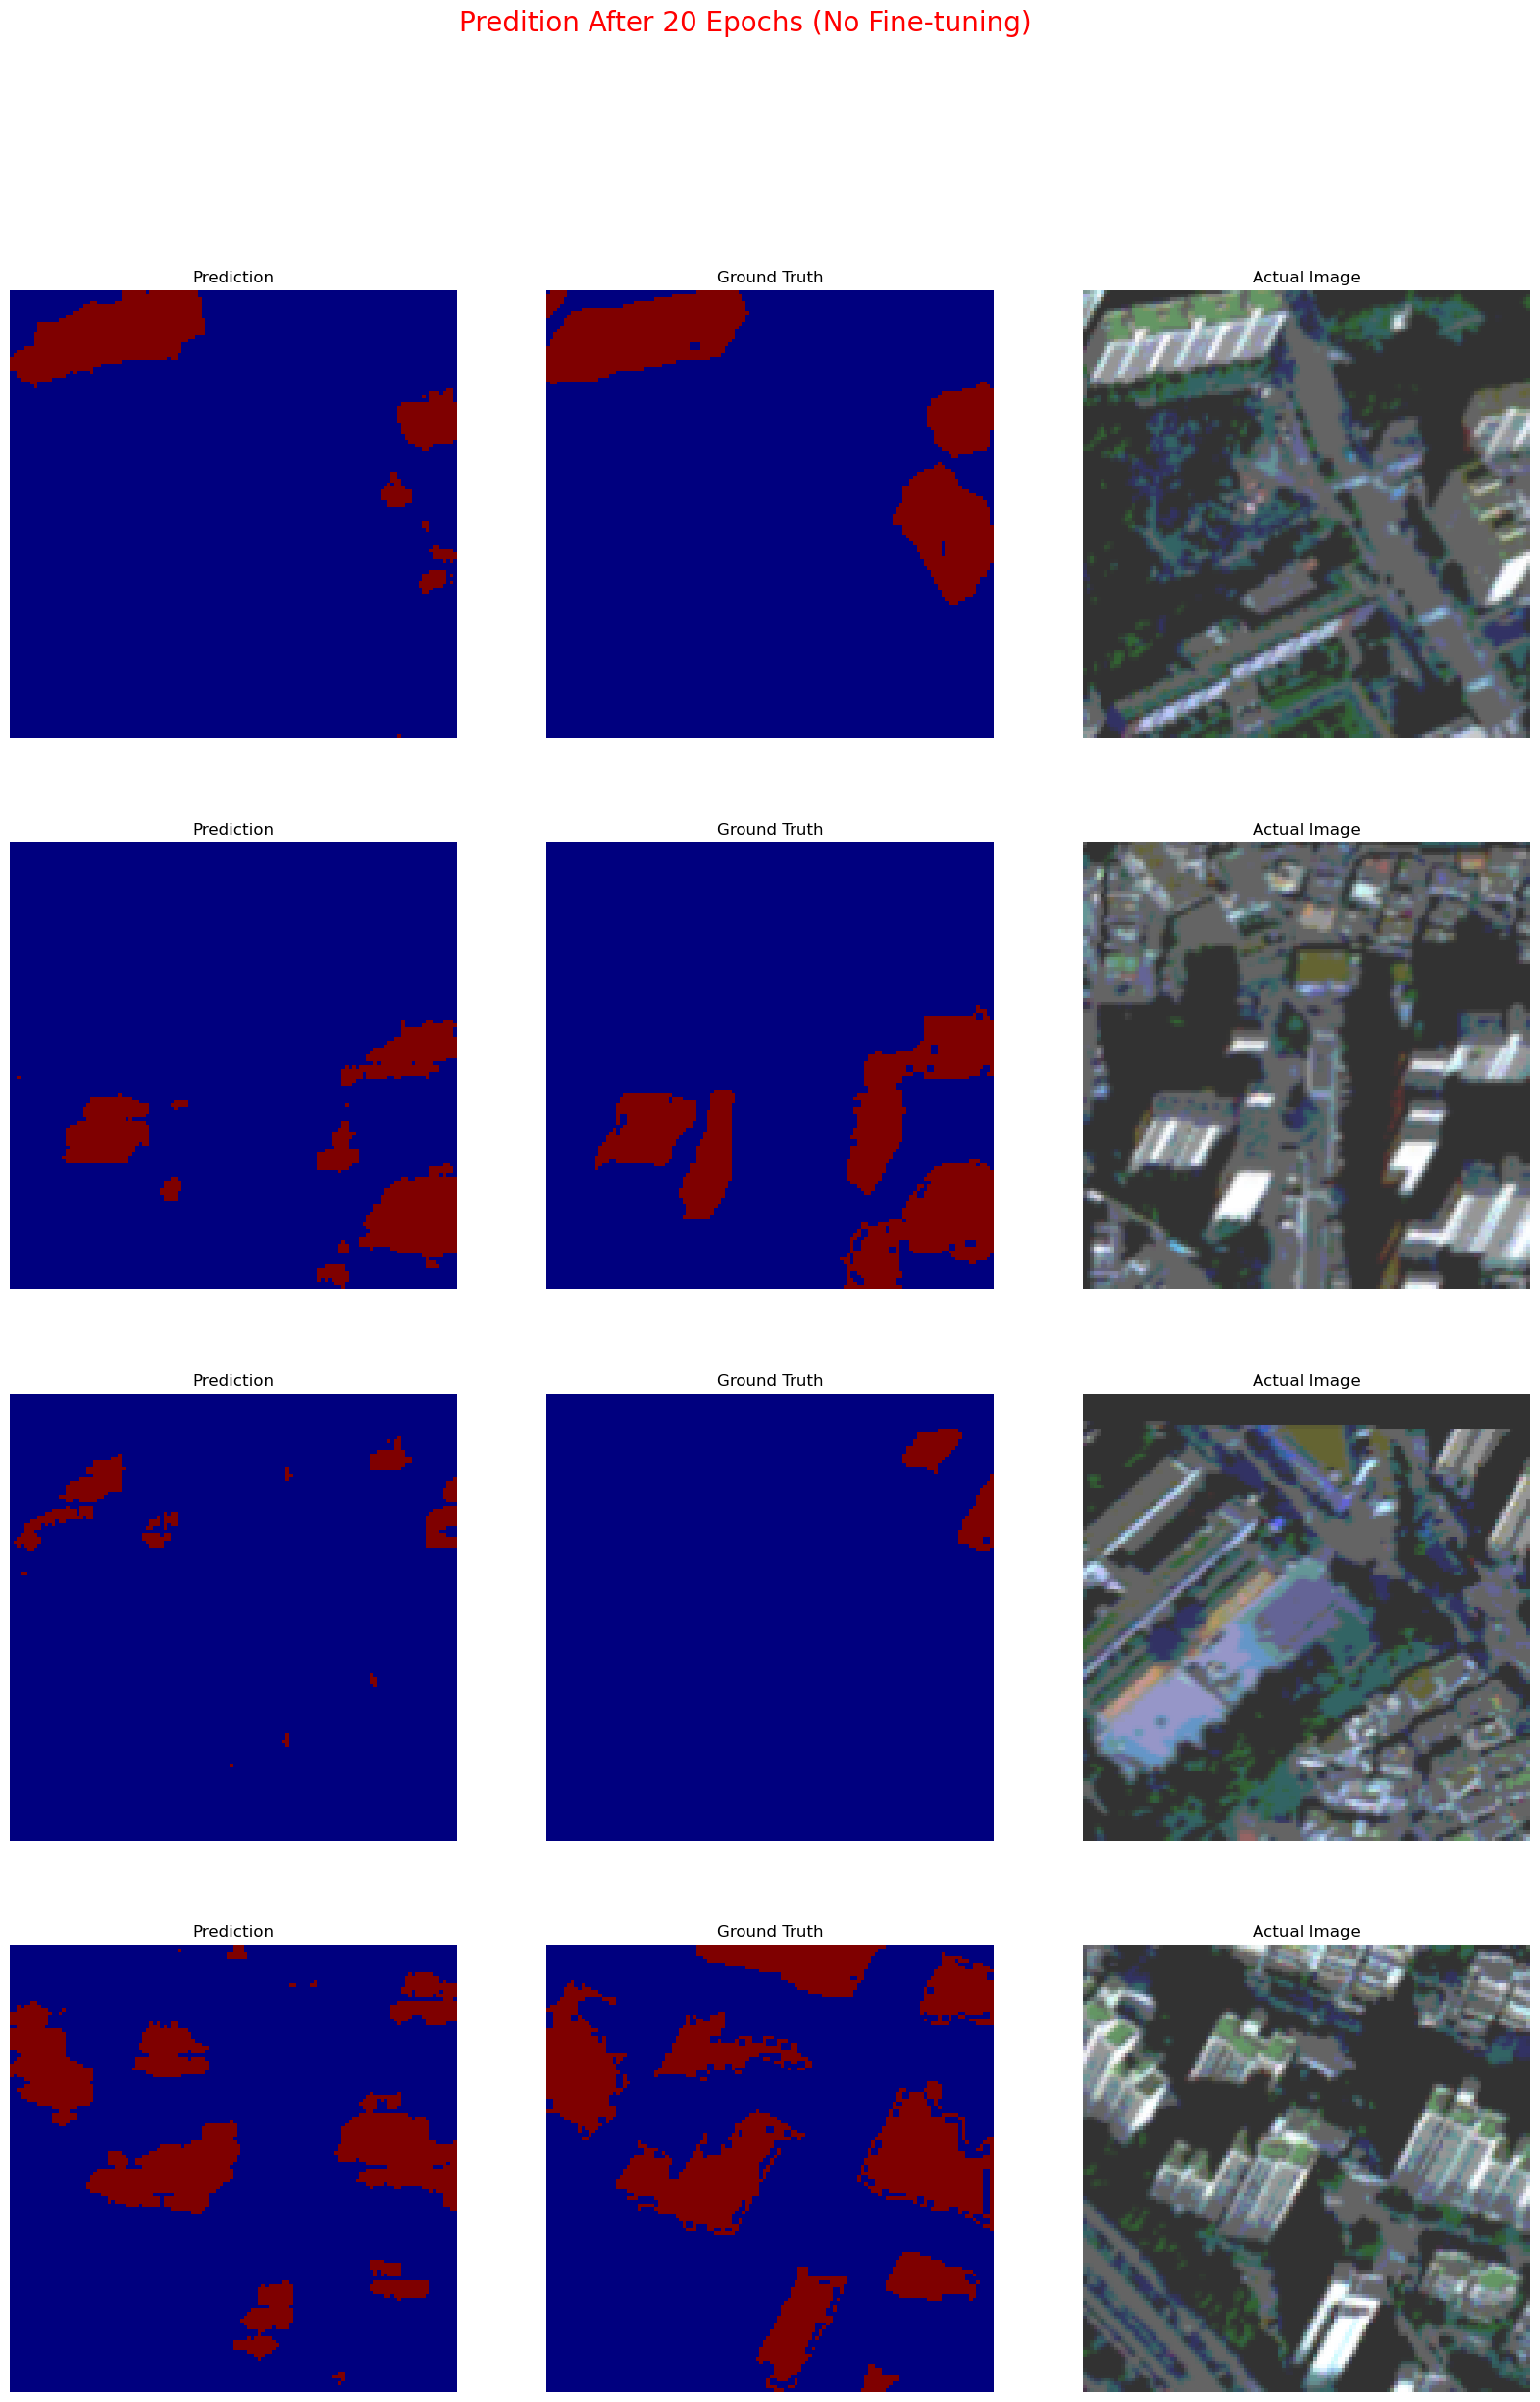

In [23]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(20,28))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet')
    plt.axis('off')
    plt.title('Prediction')

    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet')
    plt.axis('off')
    plt.title('Ground Truth')

    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 20 Epochs (No Fine-tuning)', color='red', size=20)
plt.show()

In [24]:
downstack.trainable = True
# compile again
Compile_Model()
# train from epoch 20 to 40
hist_2 = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=40, initial_epoch = 20,
               verbose = 2
                 )

Epoch 21/40
10/10 - 26s - loss: 0.1746 - accuracy: 0.9391 - val_loss: 0.1914 - val_accuracy: 0.9240 - 26s/epoch - 3s/step
Epoch 22/40
10/10 - 9s - loss: 0.1843 - accuracy: 0.9268 - val_loss: 0.3187 - val_accuracy: 0.8699 - 9s/epoch - 875ms/step
Epoch 23/40
10/10 - 9s - loss: 0.1138 - accuracy: 0.9568 - val_loss: 0.2004 - val_accuracy: 0.9205 - 9s/epoch - 882ms/step
Epoch 24/40
10/10 - 8s - loss: 0.0918 - accuracy: 0.9626 - val_loss: 0.1705 - val_accuracy: 0.9298 - 8s/epoch - 850ms/step
Epoch 25/40
10/10 - 8s - loss: 0.1204 - accuracy: 0.9531 - val_loss: 0.2978 - val_accuracy: 0.8695 - 8s/epoch - 829ms/step
Epoch 26/40
10/10 - 8s - loss: 0.1018 - accuracy: 0.9590 - val_loss: 0.4762 - val_accuracy: 0.8817 - 8s/epoch - 812ms/step
Epoch 27/40
10/10 - 8s - loss: 0.1488 - accuracy: 0.9403 - val_loss: 0.2307 - val_accuracy: 0.9152 - 8s/epoch - 819ms/step
Epoch 28/40
10/10 - 9s - loss: 0.1206 - accuracy: 0.9504 - val_loss: 0.1942 - val_accuracy: 0.9194 - 9s/epoch - 851ms/step
Epoch 29/40
10/10

1/1 [==============================] - 2s 2s/step


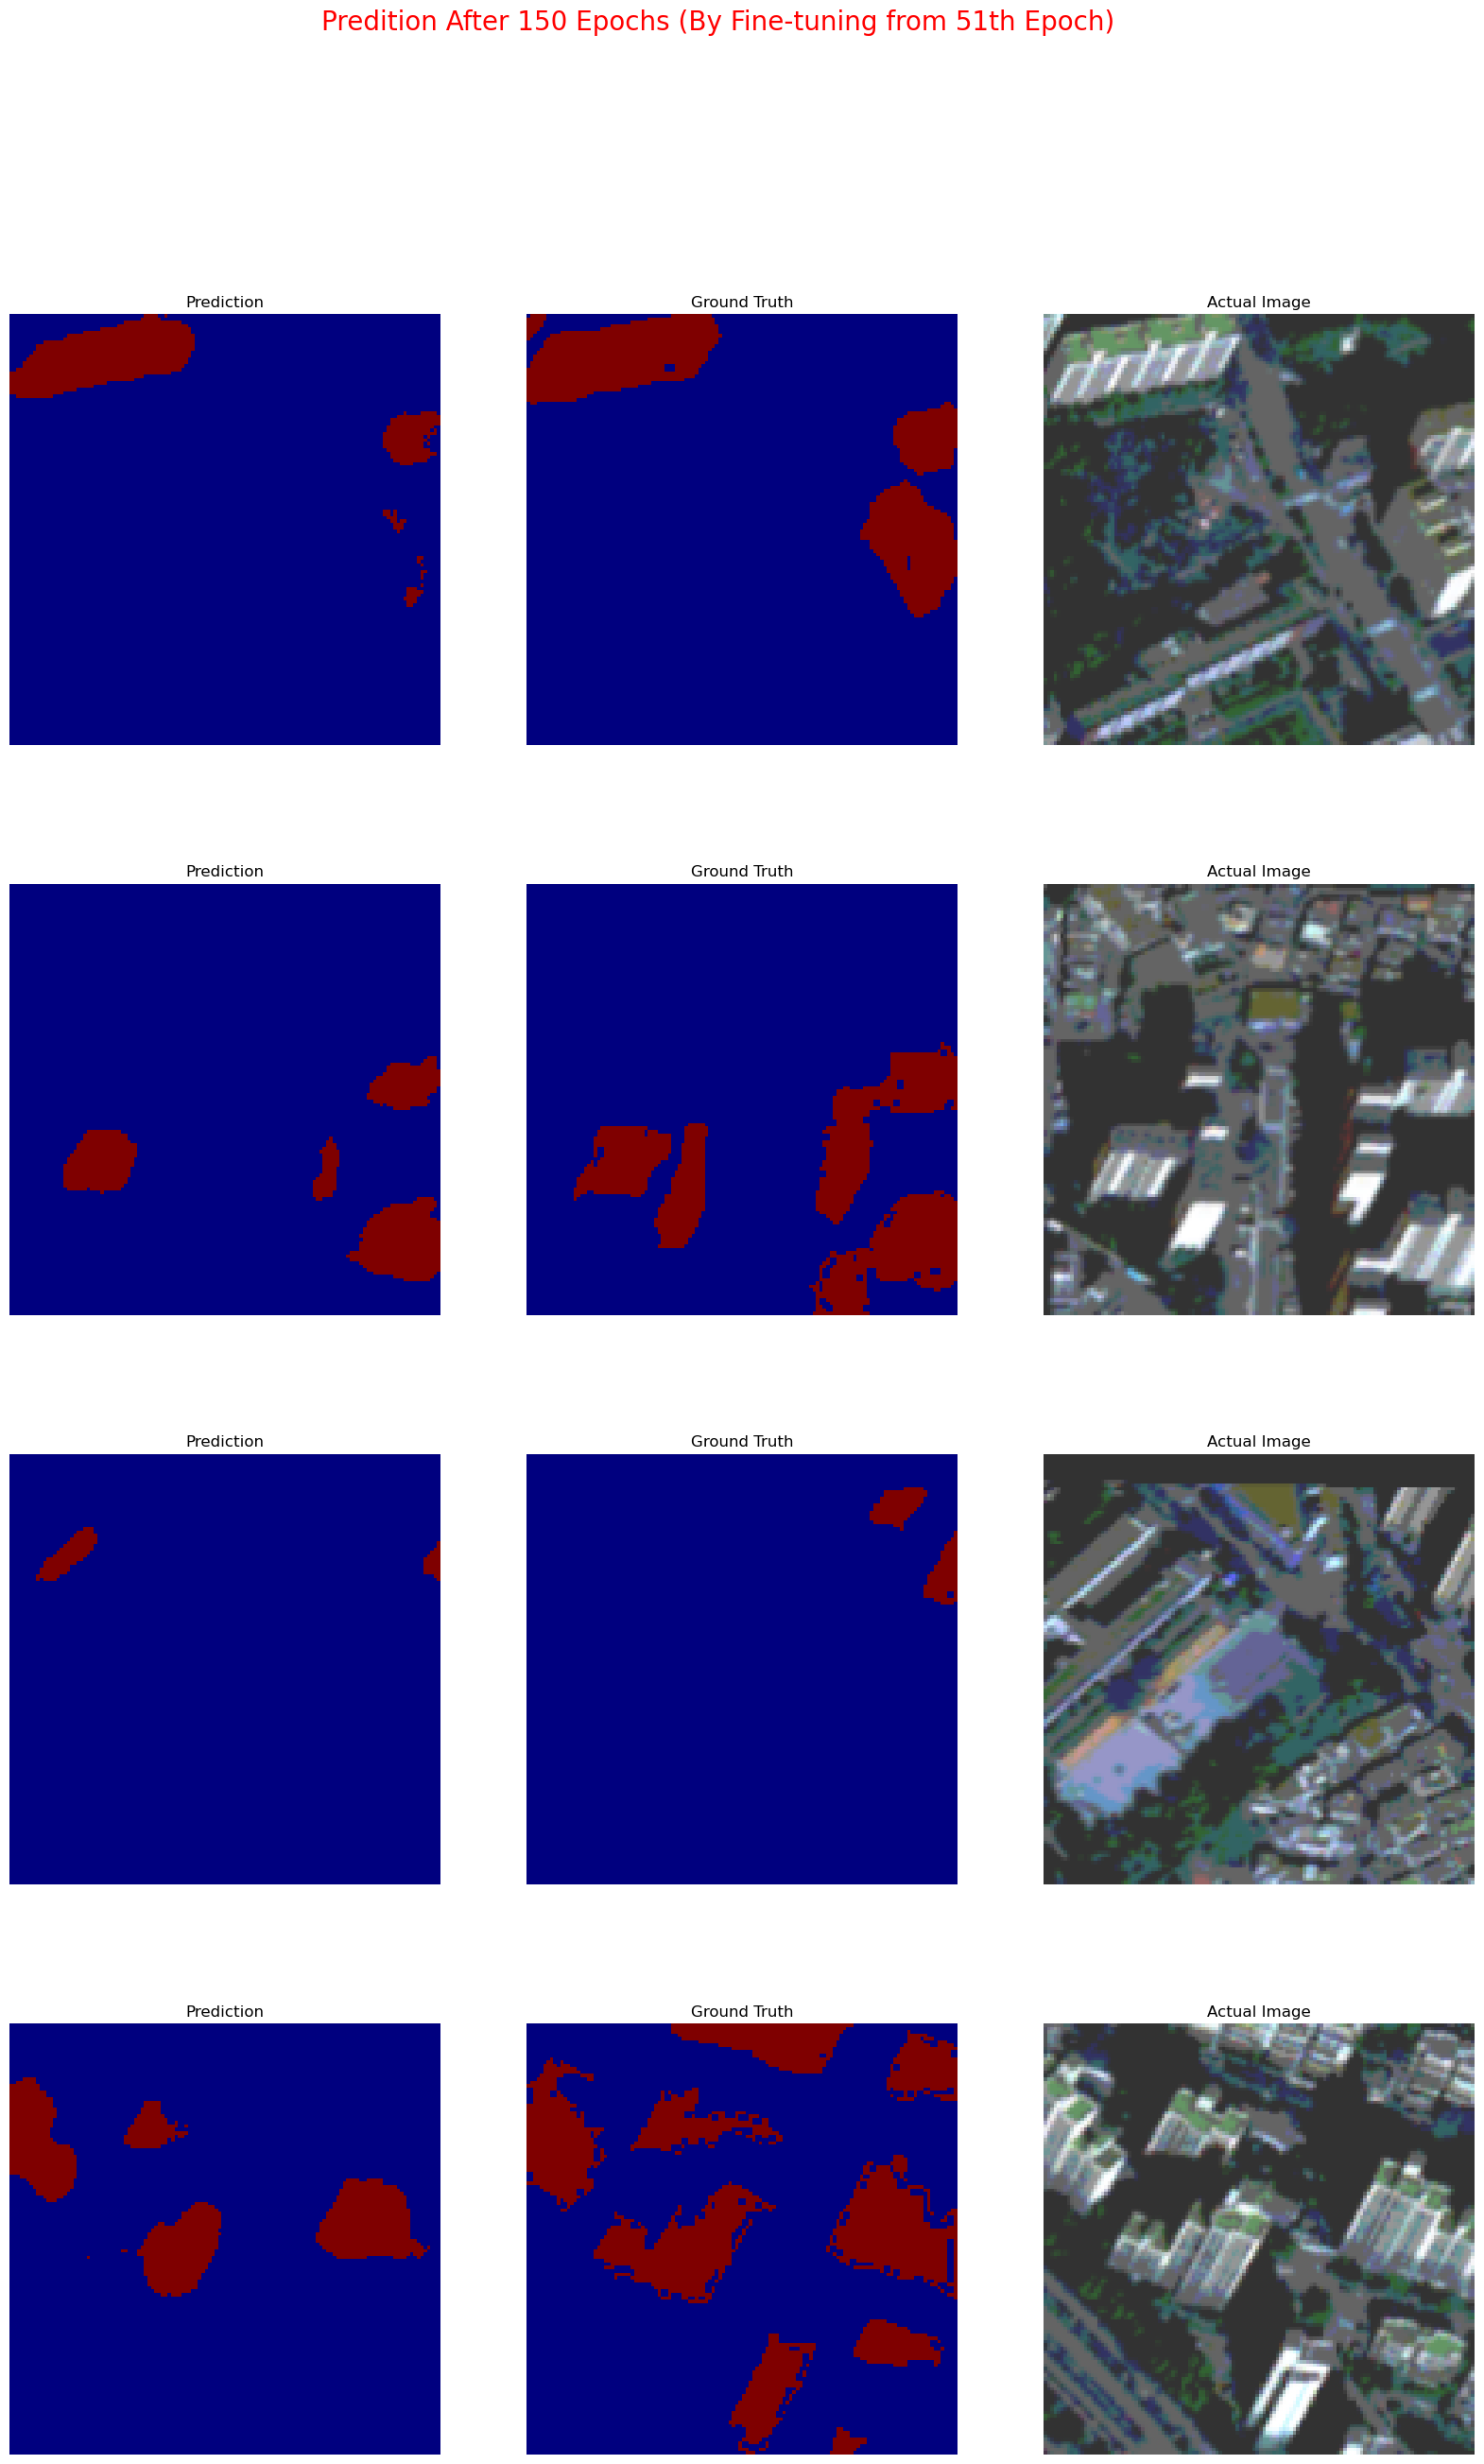

In [25]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(20,30))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet')
    plt.axis('off')
    plt.title('Prediction')

    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet')
    plt.axis('off')
    plt.title('Ground Truth')

    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 150 Epochs (By Fine-tuning from 51th Epoch)', color='red', size=20)
plt.show()